In [1]:
import lightning as L
import torch
from torch import nn,optim
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Compose,Normalize,ToTensor
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST,MNIST
from lightning.pytorch.callbacks import RichModelSummary
import matplotlib.pyplot as plt
import os
import numpy as np
import imageio

In [ ]:
dataset_path='/workspace/datasets'
batch_size=512
cpus=os.cpu_count()
torch.set_float32_matmul_precision('medium')

In [3]:
os.makedirs('./img',exist_ok=True)
transforms=Compose([ToTensor(),Normalize((0.1307,),(0.3081,))])

In [ ]:
class FashionMNISTData(L.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.batch_size=batch_size
        self.path=dataset_path
        self.transform=transforms
        self.cpus=cpus
    def prepare_data(self):
        FashionMNIST(self.path,train=True,download=True)
        FashionMNIST(self.path,train=False,download=True)
    def setup(self,stage=None):
        if stage=='fit':
            self.train,self.val=random_split(FashionMNIST(self.path,train=True,transform=self.transform),[0.85,0.15])
        if stage=='test' or stage is None:
            self.test=FashionMNIST(self.path,train=False,transform=self.transform)
    def train_dataloader(self):
        return DataLoader(self.train,batch_size=self.batch_size,num_workers=self.cpus)
    def val_dataloader(self):
        return DataLoader(self.val,batch_size=self.batch_size,num_workers=self.cpus)
    def test_dataloader(self):
        return DataLoader(self.test,batch_size=self.batch_size,num_workers=self.cpus)
    def predict_dataloader(self):
        return DataLoader(self.val,batch_size=self.batch_size,num_workers=self.cpus)
dl=FashionMNISTData()

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return (self.model(x))
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dim=100
        self.model=nn.Sequential(
            nn.Linear(self.dim,128),
            nn.LeakyReLU(),
            nn.Linear(128,256),
            nn.LeakyReLU(),
            nn.Linear(256,512),
            nn.LeakyReLU(),
            nn.Linear(512,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,784),
            nn.Tanh(),
            nn.Unflatten(1,(1,28,28))
        )
    def forward(self,x):
        return self.model(x)
with torch.no_grad():
    print(Discriminator()(Generator()(torch.randn(1,100))))
sum([p.numel() for p in Discriminator().model.parameters()]),sum([p.numel() for p in Generator().model.parameters()])

tensor([[0.4887]])


In [8]:
class GAN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.disc=Discriminator()
        self.gen=Generator()
        self.example_input_array=(torch.rand(batch_size,1,28,28))
        self.img_arr=torch.randn(9,self.gen.dim,device='cuda')
        self.automatic_optimization=False
        self.loss=F.binary_cross_entropy
        self.img_count=torch.tensor(0,requires_grad=False)

    def configure_optimizers(self):
        return [optim.Adam(self.gen.parameters(),1e-5),optim.Adam(self.disc.parameters(),1e-5)]
    
    def forward(self,x):
        return self.disc(x),self.gen(torch.rand((x.shape[0],self.gen.dim),device=x.device))
    
    def training_step(self,batch):
        imgs,targets=batch
        imgs=imgs.float()
        noise=torch.randn((targets.shape[0],self.gen.dim)).type_as(imgs)
        g_opt,d_opt=self.optimizers()

        self.toggle_optimizer(g_opt)
        self.gen_imgs=self.gen(noise)
        false_outputs=self.disc(self.gen_imgs)
        g_loss=self.loss(false_outputs,torch.full((targets.shape[0],1),0.8).type_as(imgs))

        self.log('g_loss',g_loss,prog_bar=True,logger=True)
        self.manual_backward(g_loss)
        g_opt.step()
        g_opt.zero_grad()
        self.untoggle_optimizer(g_opt)

        self.toggle_optimizer(d_opt)
        true_loss=self.loss(self.disc(imgs),torch.full((targets.shape[0],1),0.8).type_as(imgs))
        false_loss=self.loss(self.disc(self.gen_imgs.detach()),torch.full((targets.shape[0],1),0.2).type_as(imgs))
        d_loss=(true_loss+false_loss)/2
        self.log('d_loss',d_loss,prog_bar=True,logger=True)
        self.manual_backward(d_loss)
        d_opt.step()
        d_opt.zero_grad()
        self.untoggle_optimizer(d_opt)

    def validation_step(self,batch,batch_idx):
        pass

    def on_train_epoch_end(self):
        sample_imgs=(self.gen(self.img_arr)+1)/2
        grid=torchvision.utils.make_grid(sample_imgs,nrow=3).detach().cpu().numpy().T
        plt.imshow(grid)
        plt.axis(False)
        plt.savefig(f"./img/{self.img_count}.png")
        self.img_count+=1

In [9]:
model=GAN()
with torch.no_grad():
    print(GAN()(torch.randn(1,28,28)))

(tensor([[0.5086]]), tensor([[[[ 0.0067,  0.0220,  0.0147, -0.0298,  0.0396, -0.0048, -0.0056,
            0.0423,  0.0272, -0.0314,  0.0251, -0.0178, -0.0441, -0.0453,
            0.0035, -0.0200, -0.0117,  0.0050, -0.0075,  0.0299,  0.0072,
           -0.0233,  0.0212, -0.0064, -0.0129,  0.0075,  0.0178,  0.0001],
          [ 0.0248, -0.0005, -0.0518, -0.0046, -0.0443,  0.0051, -0.0097,
            0.0129, -0.0070, -0.0113, -0.0029,  0.0065,  0.0013,  0.0078,
            0.0120,  0.0169, -0.0248, -0.0320, -0.0360, -0.0426, -0.0161,
           -0.0544, -0.0083, -0.0082, -0.0220,  0.0173, -0.0196, -0.0156],
          [ 0.0255, -0.0029,  0.0062,  0.0195,  0.0479, -0.0098,  0.0182,
           -0.0047,  0.0265,  0.0012,  0.0376, -0.0124,  0.0235, -0.0140,
           -0.0490, -0.0134, -0.0241,  0.0083,  0.0026, -0.0118,  0.0300,
           -0.0054, -0.0046, -0.0013,  0.0133, -0.0410,  0.0158, -0.0046],
          [-0.0043, -0.0423, -0.0081, -0.0196, -0.0236, -0.0087, -0.0030,
           -0.

In [10]:
trainer=L.Trainer(
    max_epochs=100,
    callbacks=[RichModelSummary(max_depth=-1)]
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃    ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃         In sizes ┃        Out sizes ┃
┡━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 0  │ disc         │ Discriminator │  533 K │ train │ [512, 1, 28, 28] │         [512, 1] │
│ 1  │ disc.model   │ Sequential    │  533 K │ train │ [512, 1, 28, 28] │         [512, 1] │
│ 2  │ disc.model.0 │ Flatten       │      0 │ train │ [512, 1, 28, 28] │       [512, 784] │
│ 3  │ disc.model.1 │ Linear        │  401 K │ train │       [512, 784] │       [512, 512] │
│ 4  │ disc.model.2 │ LeakyReLU     │      0 │ train │       [512, 512] │       [512, 512] │
│ 5  │ disc.model.3 │ Linear        │  131 K │ train │       [512, 512] │       [512, 256] │
│ 6  │ disc.model.4 │ LeakyReLU     │      0 │ train │       [512, 256] │       [512, 256] │
│ 7  │ disc.model.5 │ Linear        │    257 │ train │       [512, 256] │         [512, 1] │
│ 8  │ disc.model.6 │ Sigmoid       │      0 │ train │         [512, 1] │         [512, 1] │
│ 9  │ gen          │ Generator     │  1.5 M │ train │       [512, 100] │ [512, 1, 28, 28] │
│ 10 │ gen.model    │ Sequential    │  1.5 M │ train │       [512, 100] │ [512, 1, 28, 28] │
│ 11 │ gen.model.0  │ Linear        │ 12.9 K │ train │       [512, 100] │       [512, 128] │
│ 12 │ gen.model.1  │ LeakyReLU     │      0 │ train │       [512, 128] │       [512, 128] │
│ 13 │ gen.model.2  │ Linear        │ 33.0 K │ train │       [512, 128] │       [512, 256] │
│ 14 │ gen.model.3  │ LeakyReLU     │      0 │ train │       [512, 256] │       [512, 256] │
│ 15 │ gen.model.4  │ Linear        │  131 K │ train │       [512, 256] │       [512, 512] │
│ 16 │ gen.model.5  │ LeakyReLU     │      0 │ train │       [512, 512] │       [512, 512] │
│ 17 │ gen.model.6  │ Linear        │  525 K │ train │       [512, 512] │      [512, 1024] │
│ 18 │ gen.model.7  │ LeakyReLU     │      0 │ train │      [512, 1024] │      [512, 1024] │
│ 19 │ gen.model.8  │ Linear        │  803 K │ train │      [512, 1024] │       [512, 784] │
│ 20 │ gen.model.9  │ Tanh          │      0 │ train │       [512, 784] │       [512, 784] │
│ 21 │ gen.model.10 │ Unflatten     │      0 │ train │       [512, 784] │ [512, 1, 28, 28] │
└────┴──────────────┴───────────────┴────────┴───────┴──────────────────┴──────────────────┘

Trainable params: 2.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.0 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 22                                                                                          
Modules in eval mode: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


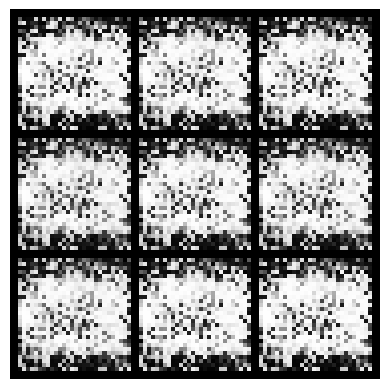

In [11]:
trainer.fit(
    model,dl
)

tensor([[0.2347]])


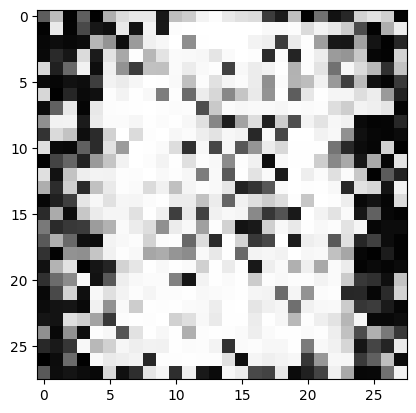

In [12]:
with torch.no_grad():
    print(model.disc.to('cpu')(model.gen.to('cpu')(torch.randn(1,100,requires_grad=False,device='cpu'))))
_=plt.imshow(model.gen(torch.randn(1,100))[0].view(28,28).detach().cpu().numpy(),cmap='gray')

In [13]:
files=np.array(os.listdir('./img'))
files=np.strings.replace(files,'.png','').astype(int)
files.sort()
files=np.repeat([os.getcwd()+'/img/'],len(files))+files.astype(str)+np.repeat('.png',len(files))
files

array(['/workspace/tf_revamp/mnist_gan/img/0.png',
       '/workspace/tf_revamp/mnist_gan/img/1.png',
       '/workspace/tf_revamp/mnist_gan/img/2.png',
       '/workspace/tf_revamp/mnist_gan/img/3.png',
       '/workspace/tf_revamp/mnist_gan/img/4.png',
       '/workspace/tf_revamp/mnist_gan/img/5.png',
       '/workspace/tf_revamp/mnist_gan/img/6.png',
       '/workspace/tf_revamp/mnist_gan/img/7.png',
       '/workspace/tf_revamp/mnist_gan/img/8.png',
       '/workspace/tf_revamp/mnist_gan/img/9.png',
       '/workspace/tf_revamp/mnist_gan/img/10.png',
       '/workspace/tf_revamp/mnist_gan/img/11.png',
       '/workspace/tf_revamp/mnist_gan/img/12.png',
       '/workspace/tf_revamp/mnist_gan/img/13.png',
       '/workspace/tf_revamp/mnist_gan/img/14.png',
       '/workspace/tf_revamp/mnist_gan/img/15.png',
       '/workspace/tf_revamp/mnist_gan/img/16.png',
       '/workspace/tf_revamp/mnist_gan/img/17.png',
       '/workspace/tf_revamp/mnist_gan/img/18.png',
       '/workspace/tf_

In [14]:
images = []
for filename in files:
    images.append(imageio.imread(filename))
imageio.mimsave('./movie.gif', images)


/tmp/ipykernel_427033/697409956.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


![image_gif](./movie.gif)